In [15]:
import os
import time
import json
import argparse
from os.path import join, exists, splitext, basename
from imp import reload
from glob import glob
import shutil

import numpy as np

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt

from pixyz.distributions import Normal, Bernoulli, RelaxedCategorical, Categorical
from pixyz.models import Model
from pixyz.losses import ELBO, NLL

batch_size = 128
epochs = 10

plt.style.use("ggplot")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
seed = 4200

mnist_labeled_path  = "./data/labeled_mnist_image"
if exists(mnist_labeled_path):
    shutil.rmtree(mnist_labeled_path)
for i in range(10):
    os.makedirs(join(mnist_labeled_path, "{}".format(i)))

batch_size = 100

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.MNIST('data/mnist', train=True, download=True, transform=transform)
unlabel_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset_test = datasets.MNIST('data/mnist', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

dataset = datasets.MNIST('data/mnist', train=True, download=True)

for i in range(seed, len(dataset)):
    for j in range(10):
        if (dataset[i][1]==j) and (len(glob(join(mnist_labeled_path, "{}/*".format(j)))) < 10):
            dataset[i][0].save(join(mnist_labeled_path, "{}/{}.png".format(j, i)))
    if len(glob(join(mnist_labeled_path, "*/*"))) == 100:
        break

        
labeled_dataset = datasets.ImageFolder(mnist_labeled_path, transform=transform)
label_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)

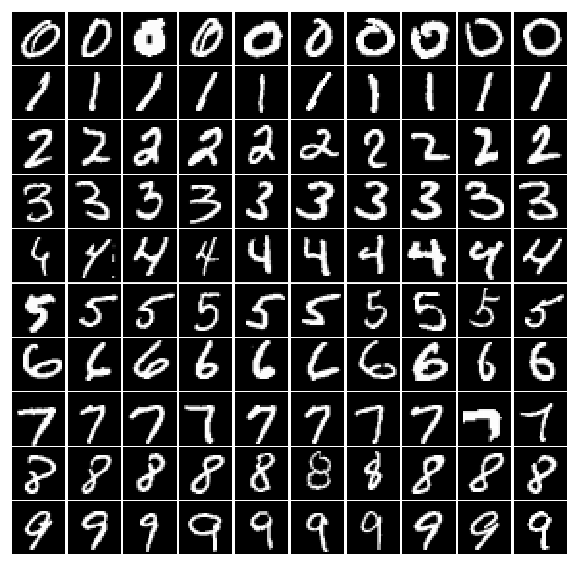

In [3]:
# ラベルつきデータの表示
samples, labels = iter(label_loader).next()
argsort = np.argsort(labels)
samples = samples[argsort]
samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1).squeeze()

# 横軸 z固定, y変化
# 縦軸 z変化, y固定
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(wspace=0., hspace=0.)
    plt.imshow(samples[i], cmap=plt.cm.gray)
plt.show()


In [4]:
class Encoder(Normal):
    def __init__(self, z_dim=63, y_dim=10):
        super(Encoder, self).__init__(cond_var=["x", "y"], var=["z"], name="q")

        self.z_dim = z_dim

        # encode
        self.conv_e = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # 28 ⇒ 14
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 14 ⇒ 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(128 * 7 *7,  40),
        )      
        self.fc2 = nn.Sequential(
            nn.Linear(128 * 7 * 7,  y_dim),
        )        
        
        self.fc = nn.Sequential(
            nn.Linear(40+y_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2*self.z_dim),
        )

    def forward(self, x, y):
        x = self.conv_e(x)
        x = x.view(-1, 128 * 7 * 7)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x = torch.cat([x1, x2*y], dim=1)
        x = self.fc(x)
        mu = x[:, :self.z_dim]
        scale = F.softplus(x[:, self.z_dim:])
        return {"loc": mu, "scale": scale}


class Decoder(Bernoulli):
    def __init__(self, z_dim=63, y_dim=10):
        super(Decoder, self).__init__(cond_var=["z", "y"], var=["x"])
        
        self.z_dim = z_dim 

        # decode
        self.fc1 = nn.Sequential(
            nn.Linear(self.z_dim, 40),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(self.z_dim, y_dim),
        )
        
        self.fc_d = nn.Sequential(
            nn.Linear(40+y_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 128 * 7 * 7),
            nn.LeakyReLU(0.2)
        )
        self.conv_d = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, z, y):
        z1 = self.fc1(z)
        z2 = self.fc2(z)
        z = torch.cat([z1, z2*y], dim=1)
        h = self.fc_d(z)
        h = h.view(-1, 128, 7, 7)
        return {"probs": self.conv_d(h)}
    
    
# classifier p(y|x)
class Classifier(RelaxedCategorical):
    def __init__(self, y_dim=10):
        super(Classifier, self).__init__(cond_var=["x"], var=["y"], temperature=0.1)
        
        self.y_dim = y_dim
        # encode
        self.conv_e = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # 28 ⇒ 14
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 14 ⇒ 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128*7*7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.y_dim),
        )
    def forward(self, x):
        x = self.conv(x)
        h = self.fc(x)
        return {"probs": h}
    

In [5]:
lr = 0.001
z_dim = 63

# prior model p(z)
loc = torch.tensor(0.).to(device)
scale = torch.tensor(1.).to(device)
prior = Normal(loc=loc, scale=scale, var=["z"], dim=z_dim)

# initialize network
E = Encoder().to(device)
D = Decoder().to(device)
C = Classifier().to(device)
D_j = D * prior
D_j.to(device)

p(z) (Normal): Normal()
p(x|z,y) (Bernoulli): Decoder(
  (fc1): Sequential(
    (0): Linear(in_features=63, out_features=40, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=63, out_features=10, bias=True)
  )
  (fc_d): Sequential(
    (0): Linear(in_features=50, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
  )
  (conv_d): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Sigmoid()
  )
)

In [7]:
print(E.prob_text)
print(D.prob_text)
print(C.prob_text)
print(D_j.prob_text)

q(z|x,y)
p(x|z,y)
p(y|x)
p(x,z|y)


In [9]:
# distributions for unsupervised learning
Eu = E.replace_var(x="x_u", y="y_u")
Du = D.replace_var(x="x_u", y="y_u")
Cu = C.replace_var(x="x_u", y="y_u")

ECu = Eu * Cu
Du_j = Du * prior

Du_j.to(device)
ECu.to(device)
Cu.to(device)

print(Du_j)
print(ECu)
print(Cu)

Distribution:
  p(x_u,z|y_u) = p(x_u|z,y_u)p(z)
Network architecture:
  p(z) (Normal): Normal()
  p(x_u|z,y_u) (Bernoulli): Decoder(
    (fc1): Sequential(
      (0): Linear(in_features=63, out_features=40, bias=True)
    )
    (fc2): Sequential(
      (0): Linear(in_features=63, out_features=10, bias=True)
    )
    (fc_d): Sequential(
      (0): Linear(in_features=50, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Linear(in_features=1024, out_features=6272, bias=True)
      (4): LeakyReLU(negative_slope=0.2)
    )
    (conv_d): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): Sigmoid()

In [16]:
elbo_u = ELBO(Du_j, ECu)
elbo = ELBO(D_j, E)
nll = NLL(C)

rate = 1 * (len(unlabel_loader) + len(label_loader)) / len(label_loader)

loss_cls = -elbo_u.mean() -elbo.mean() + (rate * nll).mean() 
print(loss_cls)

# 最適化
model = Model(loss_cls,test_loss=nll.mean(),
              distributions=[E, D, C], optimizer=optim.Adam, optimizer_params={"lr":1e-3})
print(model)


-(mean(E_p(z,y_u|x_u)[log p(x_u,z|y_u)/p(z,y_u|x_u)])) - mean(E_q(z|x,y)[log p(x,z|y)/q(z|x,y)]) + mean(log p(y|x) * 601.0)
Distributions (for training): 
  q(z|x,y), p(x|z,y), p(y|x) 
Loss function: 
  -(mean(E_p(z,y_u|x_u)[log p(x_u,z|y_u)/p(z,y_u|x_u)])) - mean(E_q(z|x,y)[log p(x,z|y)/q(z|x,y)]) + mean(log p(y|x) * 601.0) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


In [ ]:
def train(epoch):
    train_loss = 0
    for (x, y), (x_u, y_u) in tqdm(zip(cycle(labelled), unlabelled), total=len(unlabelled)):
        x = x.to(device)
        y = torch.eye(10)[y].to(device)
        x_u = x_u.to(device)        
        loss = model.train({"x": x, "y": y, "x_u": x_u})
        train_loss += loss
        
    train_loss = train_loss * unlabelled.batch_size / len(unlabelled.dataset)
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    
    return train_loss